# Solutions to Chaos Game Representation

In [56]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import random
import csv
import sympy
from sympy.ntheory.continued_fraction import continued_fraction_iterator
import skimage.io
from skimage.metrics import structural_similarity as ssim
import pickle
import seaborn as sns
import pandas as pd
from sklearn import manifold, decomposition
import multiprocessing as mp
import os

__Activity:__ Playing with the coefficients of the transformation functions will create mutate fern varieties. One example of a mutant has the following IFS

|   w   |   a   |   b   |   c    |   d   |   e    |   f   |   p   |
|-------|-------|-------|--------|-------|--------|-------|-------|
| 1     | 0.00  | 0.00  | 0.00   | 0.25  | 0.00   | -0.4  | 0.02  |
| 2     | 0.95  | 0.005 | -0.005 | 0.93  | -0.002 | 0.5   | 0.84  |
| 3     | 0.035 | -0.2  | 0.16   | 0.04  | -0.09  | 0.02  | 0.07  |
| 4     | -0.04 | 0.2   | 0.16   | 0.04  | 0.083  | 0.12  | 0.07  |

a) Modify the given Barnsley fern code to create the mutant given by the IFS above. What are the differences between the original Barnsley fern and the mutant?

b) Create your own Barnsley fern mutate by changing the coefficients.

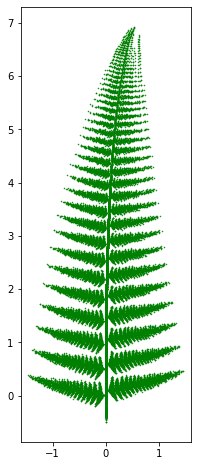

In [8]:
# Part a)
n = 50000

fern = np.zeros((2, n))

for i in range(1, n):
    r = random.random()
    if r <= 0.02:
        fern[:, i] = np.array([[0, 0], [0, 0.25]]).dot(fern[:, i-1]) + np.array([0, -0.4])
    elif r <= 0.86:
        fern[:, i] = np.array([[0.95, 0.005], [-0.005, 0.93]]).dot(fern[:, i-1]) + np.array([-0.002, 0.5])
    elif r <= 0.93:
        fern[:, i] = np.array([[0.035, -0.2], [0.16, 0.04]]).dot(fern[:, i-1]) + np.array([-0.09, 0.02])
    else:
        fern[:, i] = np.array([[-0.04, 0.2], [0.16, 0.04]]).dot(fern[:, i-1]) + np.array([0.083, 0.12])

fig = plt.figure(figsize=(8, 8))
plt.plot(fern[0, :], fern[1, :], 'g.', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

For Part b, we will use the following IFS:

|   w   |   a   |   b   |   c    |   d   |   e    |   f   |   p   |
|-------|-------|-------|--------|-------|--------|-------|-------|
| 1     | 0.00  | 0.00  | 0.00   | 0.25  | 0.00   | -0.14 | 0.02  |
| 2     | 0.85  | 0.02  | -0.02  | 0.83  | 0.00   | 1     | 0.84  |
| 3     | 0.09  | -0.28 | 0.3    | 0.11  | 0.00   | 0.6   | 0.07  |
| 4     | -0.09 | 0.28  | 0.3    | 0.09  | 0.00   | 0.7   | 0.07  |

which gives the following results

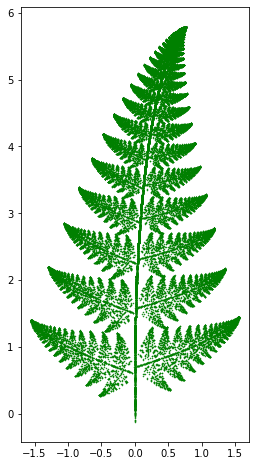

In [9]:
# Part b)
n = 50000

fern = np.zeros((2, n))

for i in range(1, n):
    r = random.random()
    if r <= 0.02:
        fern[:, i] = np.array([[0, 0], [0, 0.25]]).dot(fern[:, i-1]) + np.array([0, -0.14])
    elif r <= 0.86:
        fern[:, i] = np.array([[0.85, 0.02], [-0.02, 0.83]]).dot(fern[:, i-1]) + np.array([0, 1])
    elif r <= 0.93:
        fern[:, i] = np.array([[0.09, -0.28], [0.3, 0.1]]).dot(fern[:, i-1]) + np.array([0, 0.6])
    else:
        fern[:, i] = np.array([[-0.09, 0.28], [0.3, 0.09]]).dot(fern[:, i-1]) + np.array([0, 0.7])

fig = plt.figure(figsize=(8, 8))
plt.plot(fern[0, :], fern[1, :], 'g.', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

__Activity:__ [Paul Bourke's website](http://paulbourke.net/fractals/ifs/) provides several images produced by IFS. Replicate some of these examples using Python.

In [51]:
# Create generalized function to perform IFS

def IFS(param, n):

#   Inputs:
#       param: np.array, where the number of rows is the number of functions used in the IFS, and the columns correspond to a, b, c, d, e, f, p
#       n: number of iterations
#   Output:
#       coord: the coordinates of the IFS

    coord = np.zeros((2, n))
    
    prob_list = np.cumsum(param[:, -1])
    
    for i in range(1, n):
        r = random.random()
        for j in range(len(prob_list)):
            if r < prob_list[j]:
                ind = j
                break
        coord[:, i] = param[ind, :4].reshape((2, 2)).dot(coord[:, i-1]) + param[ind, 4:6]
        
    return(coord)

_IFS Spiral Parameter table:_

|   w   |     a     |     b     |     c     |     d     |     e     |     f     |   p   |
|-------|-----------|-----------|-----------|-----------|-----------|-----------|-------|
| 1     | 0.787879  | -0.424242 | 0.242424  | 0.859848  | 1.758647  | 1.408065  | 0.90  |
| 2     | -0.121212 | 0.257576  | 0.151515  | 0.053030  | -6.721654 | 1.377236  | 0.05  |
| 3     | 0.181818  | -0.136364 | 0.090909  | 0.181818  | 6.086107  | 1.568035  | 0.05  |

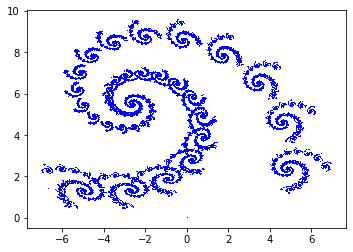

In [55]:
spiral_param = np.array([[0.787879, -0.424242, 0.242424, 0.859848, 1.758647, 1.408065, 0.90],
                         [-0.121212, 0.257576, 0.151515, 0.053030, -6.721654, 1.377236, 0.05],
                         [0.181818, -0.136364, 0.090909, 0.181818, 6.086107, 1.568035, 0.05]])
spiral = IFS(spiral_param, 50000)
plt.plot(spiral[0, :], spiral[1, :], 'b,')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

_Maple Leaf Parameter Table:_

|   w   |   a   |   b   |   c    |   d   |   e    |   f   |   p   |
|-------|-------|-------|--------|-------|--------|-------|-------|
| 1     | 0.14  | 0.01  | 0.00   | 0.51  | -0.08  | -1.31 | 0.25  |
| 2     | 0.43  | 0.52  | -0.45  | 0.50  | 1.49   | -0.75 | 0.25  |
| 3     | 0.45  | -0.49 | 0.47   | 0.47  | -1.62  | -0.74 | 0.25  |
| 4     | 0.49  | 0.00  | 0.00   | 0.51  | 0.02   | 1.62  | 0.25  |

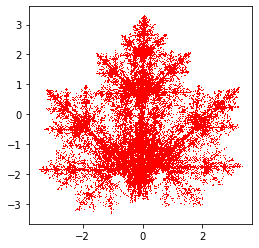

In [46]:
leaf_param = np.array([[0.14, 0.01, 0.00, 0.51, -0.08, -1.31, 0.25],
                 [0.43, 0.52, -0.45, 0.50, 1.49, -0.75, 0.25],
                 [0.45, -0.49, 0.47, 0.47, -1.62, -0.74, 0.25],
                 [0.49, 0.00, 0.00, 0.51, 0.02, 1.62, 0.25]])
leaf = IFS(leaf_param, 50000)
plt.plot(leaf[0, :], leaf[1, :], 'r,')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Tree Parameter Table:

|   w   |   a   |   b   |   c    |   d   |   e    |   f   |   p   |
|-------|-------|-------|--------|-------|--------|-------|-------|
| 1     | 0.05  | 0.00  | 0.00   | 0.40  | -0.06  | -0.47 | 0.143 |
| 2     | -0.05 | 0.00  | 0.00   | -0.40 | -0.06  | -0.47 | 0.143 |
| 3     | 0.03  | -0.14 | 0.00   | 0.26  | -0.16  | -0.01 | 0.143 |
| 4     | -0.03 | 0.14  | 0.00   | -0.26 | -0.16  | -0.01 | 0.143 |
| 5     | 0.56  | 0.44  | -0.37  | 0.51  | 0.30   | 0.15  | 0.143 |
| 6     | 0.19  | 0.07  | -0.10  | 0.15  | -0.02  | 0.28  | 0.143 |
| 7     | -0.33 | -0.34 | -0.33  | 0.34  | -0.54  | 0.39  | 0.143 |

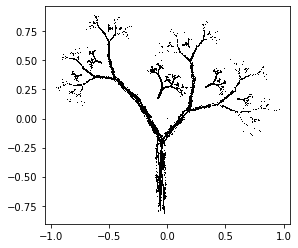

In [54]:
tree_param = np.array([[0.05, 0.00, 0.00, 0.40, -0.06, -0.47, 0.143],
                       [-0.05, 0.00, 0.00, -0.40, -0.06, -0.47, 0.143],
                       [0.03, -0.14, 0.00, 0.26, -0.16, -0.01, 0.143],
                       [-0.03, 0.14, 0.00, -0.26, -0.16, -0.01, 0.143],
                       [0.56, 0.44, -0.37, 0.51, 0.30, 0.15, 0.143],
                       [0.19, 0.07, -0.10, 0.15, -0.02, 0.28, 0.143],
                       [-0.33, -0.34, -0.33, 0.34, -0.54, 0.39, 0.143]])
tree = IFS(tree_param, 50000)
plt.plot(tree[0, :], tree[1, :], 'k,')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

__Activity__: Using the provided code (or if you're brave, write your own), create a generalized CGR of a 6, 9, and 12-sided polygon (using the dividing rate formula by Almeida).

In [40]:
def n_gon(n, *start):
    if start:
        deg = np.linspace(start[0], start[0] + 360, n+1)
    else:
        deg = np.linspace(0, 360, n+1)
    deg = deg[:-1]
    rad = []
    for d in deg:
        rad.append((d/360)*2*math.pi)
    cor = np.zeros((2, n+1))
    for r in range(len(rad)):
        x = math.cos(rad[r])
        y = math.sin(rad[r])
        cor[:, r] = np.array([x, y])
    cor[:, n] = cor[:, 0]
    return cor

def dividingRateAlmeida(n):
    k = round((n+2.)/4.)
    s_num = 2*math.cos(math.pi*((1/2) - (k/n))) - 2*math.cos(math.pi*((1/2)-(1/(2*n))))*math.cos((2*k-1)*(math.pi/(2*n)))*(1 + (math.tan((2*k-1)*(math.pi/(2*n))))/(math.tan(math.pi-((n+2*k-2)*(math.pi/(2*n))))))
    s_den = 2*math.cos(math.pi*((1/2) - (k/n)))
    return s_num/s_den

def generalizedCGR(N, divide_func, n, *start):
    if start:
        shape_coord = n_gon(n, start[0])
    else:
        shape_coord = n_gon(n)
    r = divide_func(n)
    dataPoints = np.zeros((2, N))
    for i in range(1, N):
        rand = random.random()
        dataPoints[:, i] = dataPoints[:, i-1] + (shape_coord[:, math.floor(n*rand)] - dataPoints[:, i-1])*r
    return(r, shape_coord, dataPoints)

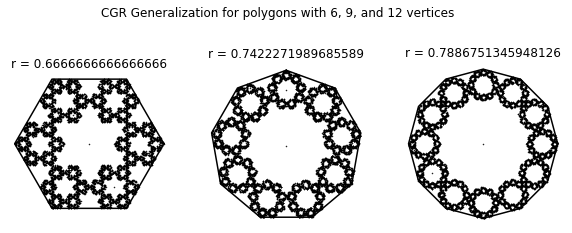

In [26]:
N = 10000
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('CGR Generalization for polygons with 6, 9, and 12 vertices')

(r, coord, points) = generalizedCGR(N, dividingRateAlmeida, 6, 0)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('r = {}'.format(r))

(r, coord, points) = generalizedCGR(N, dividingRateAlmeida, 9, 90)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('r = {}'.format(r))

(r, coord, points) = generalizedCGR(N, dividingRateAlmeida, 12, 0)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('r = {}'.format(r))

plt.show()

__Activity__: Produce your own CGR of DNA sequences of your chosing. Pick sequences that are from difference species, such as plants, fungi, protists, etc. It is recommended that the length of the sequence does not exceed 50000 bp. Compare the CGRs of the difference species visually? Are there any species in which their CGRs are similar to one another? How about species in which their CGRs are most different from each other?

__Activity:__ Create a molecular distance map of the mitochondrion DNA of molluscs. The Fasta files are provided to you and can be found in the `Supplementary Material/Activities/Molluscs/Fasta Files` folder.

In [57]:
def parse_sequence(filename):
    with open(filename) as inputfile:
        next(inputfile)
        results = list(csv.reader(inputfile))
    seq = ''
    for r in results[:-1]:
        seq = seq + r[0]
    return seq

def dna_cgr(seq):
    N = len(seq)
    dataPoints = np.zeros((2, N+1))
    dataPoints[:, 0] = np.array([0.5, 0.5])
    for i in range(1, N+1):
        if seq[i-1] == 'A':
            corner = np.array([0, 0])
        elif seq[i-1] == 'C':
            corner = np.array([0, 1])
        elif seq[i-1] == 'G':
            corner = np.array([1, 1])
        else:
            corner = np.array([1, 0])
        dataPoints[:, i] = 0.5*(dataPoints[:, i-1] + corner)
    return(dataPoints)

def plot_CGR(coord, filename):
    plt.figure()
    plt.plot(coord[0, :], coord[1, :], 'k,')
    plt.axis('off')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.gca().set_aspect('equal', 'box')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

def make_CGR(fasta_file, output_file):
    sequence = parse_sequence(fasta_file)
    coordinate = dna_cgr(sequence)
    cgr = plot_CGR(coordinate, output_file)

In [58]:
# Make CGRs
f = []
for (dirpath, dirnames, filenames) in os.walk('../Supplementary Material/Activities/Molluscs/Fasta Files'):
    for name in filenames:
        f.append(os.path.join(dirpath, name))

for file in f:
    index = file.find('/', 12)
    animal_class = file[12:index]
    animal_id = file[index+1:-6]
    path = '../Supplementary Material/Activities/Molluscs/CGR/'+animal_class
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
    make_CGR(file, path+'/'+animal_id+'.png')

__Activity:__ Create a molecular distance map of the cytochrome b (mitochondrion) protein in all land plants. Fasta files are located in the `Supplementary Material/Activities/Land Plants/Fasta Files` folder.

__Activity:__ Create a square CGR for the digits of $pi$ by reading 2 digits at a time (as explained above). Assign the two-digit numbers a corner by the following two methods:
a) taking the modulo (base 4) and assigning the corners 0, 1, 2, 3
b) assigning the corners to cover the values 0-24, 25-49, 50-74, and 75-99, respectively.
Do the CGRs look different from one another? What conclusions can you draw from the two CGRs?

__Activity:__ Repeat the above exercise with the digits of $e = 2.71828...$

__Activity:__ Create another CGR using the partial quotients of a continued fraction of any irrational number of your choosing. Feel free to use CGRs with different number of vertices or grouping the numbers in different ways (such as what we did for the digits of $\pi$ in a previous activity).

In [38]:
def confrac(expr, n):
    result = []
    for i, v in enumerate(continued_fraction_iterator(expr)):
        if i > (n-1):
            break
        result.append(v)
    return(result)

def numeric_cgr(seq, n_ver, *start):
    N = len(seq)
    if start:
        vertices = n_gon(n_ver, start[0])
    else:
        vertices = n_gon(n_ver, 0)
    r = dividingRateAlmeida(n_ver)
    dataPoints = np.zeros((2, N+1))
    for i in range(1, N+1):
        index = seq[i-1]%n_ver
        dataPoints[:, i] = dataPoints[:, i-1] + (vertices[:, index] - dataPoints[:, i-1])*r
    return(vertices, dataPoints)

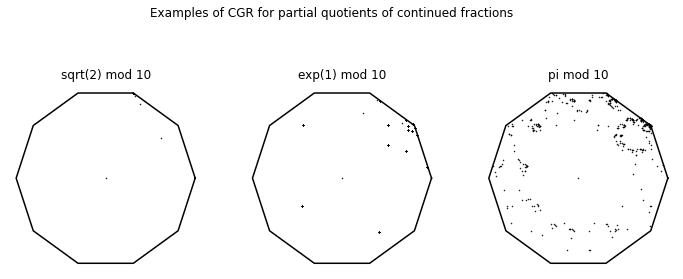

In [41]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Examples of CGR for partial quotients of continued fractions')

pq_sqrt2 = confrac(sympy.sqrt(2), 200)
(coord, points) = numeric_cgr(pq_sqrt2, 10, 0)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('sqrt(2) mod 10')

pq_exp = confrac(sympy.exp(1), 200)
(coord, points) = numeric_cgr(pq_exp, 10, 0)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('exp(1) mod 10')

pq_pi = confrac(sympy.pi, 450)
(coord, points) = numeric_cgr(pq_pi, 10, 0)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('pi mod 10')

plt.show()